<a href="https://colab.research.google.com/github/ekdpf3636-jpg/fx-tourism-forecast/blob/main/PythonTeamProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 방문객 avg 전처리 (국가명 한 컬럼 제외)
import pandas as pd
import numpy as np

def load_visitors_monthly_long(path):
    raw = pd.read_csv(path, encoding="cp949", header=0)
    header = raw.iloc[1].tolist()
    df = raw.iloc[2:].copy()
    df.columns = header

    # 1) 'Country' 컬럼 표준화: 없으면 '국가명'을 'Country'로, 그것도 없으면 첫번째 컬럼을 'Country'로
    if "Country" not in df.columns:
        if "국가명" in df.columns:
            df.rename(columns={"국가명": "Country"}, inplace=True)
        else:
            df.rename(columns={df.columns[0]: "Country"}, inplace=True)

    # 2) '국가명'이 여전히 존재하면 드롭
    if "국가명" in df.columns:
        df.drop(columns=["국가명"], inplace=True)

    # 3) 월 컬럼만 선별
    month_cols = [c for c in df.columns if isinstance(c, str) and "." in c and "월" in c]

    # 4) Country + 월 컬럼만 사용
    dfm = df[["Country"] + month_cols].copy()
    dfm["Country"] = dfm["Country"].ffill()

    # 5) Long 형태로 변환
    long_df = dfm.melt(id_vars=["Country"], var_name="ym_str", value_name="visitors")

    # 6) 방문객 숫자 정리
    long_df["visitors"] = (long_df["visitors"].astype(str)
                           .str.replace(",", "", regex=False)
                           .str.strip())
    long_df["visitors"] = pd.to_numeric(long_df["visitors"], errors="coerce")

    # 7) "YYYY.M월" → Timestamp(YYYY-MM-01)
    def parse_year_month(s):
        try:
            y, m = s.split(".")
            y = int(y); m = int(m.replace("월","").strip())
            return pd.Timestamp(y, m, 1)
        except:
            return pd.NaT

    long_df["date"] = long_df["ym_str"].apply(parse_year_month)
    long_df = long_df.dropna(subset=["date"]).drop(columns=["ym_str"])
    long_df["date"] = pd.to_datetime(long_df["date"]).dt.strftime("%Y-%m")

    # 반환시 "국가명" 컬럼 제외
    return long_df[["Country","date","visitors"]].sort_values(["Country","date"]).reset_index(drop=True)

# csv 파일로 저장하기
vis_long = load_visitors_monthly_long("전체국가통계_202506.csv")
vis_long.to_csv("국가별_방문객통계.csv", index=False, encoding="cp949")

In [ ]:
# 원본 데이터엔 중복된 한글 컬럼과 G.TOTAL 등 필요없는 데이터들이 포함되어있습니다 앞에 있을 환율 데이터와 병합을 위해서
# Country 컬럼을 Long 형태로 변환 하고 국가 마다 각 년도 여행객 수를 보기 쉽게 컬럼을 Country , date , visitors 로 정리 했습니다.

In [ ]:
# 환율 데이터 전처리 (date 컬럼을 맨 앞으로)
import pandas as pd

def load_fx_one(path, currency_tag):
    raw = pd.read_csv(path, encoding="cp949", header=0)
    header = raw.iloc[1].tolist()
    df = raw.iloc[2:].copy()
    df.columns = header

    col_date = [c for c in df.columns if "날짜" in str(c)][0]
    col_won  = [c for c in df.columns if str(c).strip().endswith("원")][-1]

    out = df[[col_date, col_won]].copy()
    out.rename(columns={col_date: "ym", col_won: currency_tag}, inplace=True)

    out[currency_tag] = (out[currency_tag].astype(str)
                         .str.replace(",", "", regex=False)
                         .str.strip())
    out[currency_tag] = pd.to_numeric(out[currency_tag], errors="coerce")

    def parse_ym(s):
        try:
            y, m = s.split(".")
            return pd.Timestamp(int(y), int(m), 1)
        except:
            return pd.NaT

    # 날짜 형식
    out["date"] = out["ym"].apply(parse_ym)
    out = out.dropna(subset=["date"]).drop(columns=["ym"]).sort_values("date")
    # ✅ 날짜 형식을 YYYY-MM으로 통일 (← 여기만 바뀜)
    out["date"] = out["date"].dt.strftime("%Y-%m")
    return out

# 통화별 로드
fx_usd = load_fx_one("달러.csv", "usd_krw")
fx_jpy = load_fx_one("엔화.csv", "jpy100_krw")  # 100엔 기준
fx_eur = load_fx_one("유로.csv", "eur_krw")

# 병합
fx_all = (
    fx_usd
    .merge(fx_jpy, on="date", how="outer")
    .merge(fx_eur, on="date", how="outer")
    .sort_values("date"))

# 안전하게 date를 맨 앞으로 정렬
fx_all = fx_all[["date"] + [c for c in fx_all.columns if c != "date"]]
# 문자열 YYYY-MM 로 확정 -> csv 파일에 day 출력 X
fx_all["date"] =  fx_all["date"].astype(str)

# 저장 & 다운로드
fx_all.to_csv("달러_엔_유로_원화환율.csv", index=False, encoding="cp949")

In [ ]:
# 환율 원본 데이터는 USD , JPY , EUR 로 각각 세개의 데이터 파일을 받았습니다. 각 파일들 데이터를 살펴보면
# 월평균 매매기준율, 기간, 한글 컬럼들을 정리한 후 날짜 데이터 형식을 YYYY-MM 로 변경해서
# 년도 별 USD , JPY , EUR 원화 기준 환율로 보기쉽게 정리하고 3개의 환율 데이터를 병합했습니다

In [ ]:
# 여행객/환율 병합
vis_fx = vis_long.merge(fx_all, on="date", how="left")
vis_fx.to_csv("환율대비_여행객수.csv", index=False, encoding="utf-8")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

/tmp/ipython-input-2166874724.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_countries_df['Country'] = real_countries_df['Country'].replace(


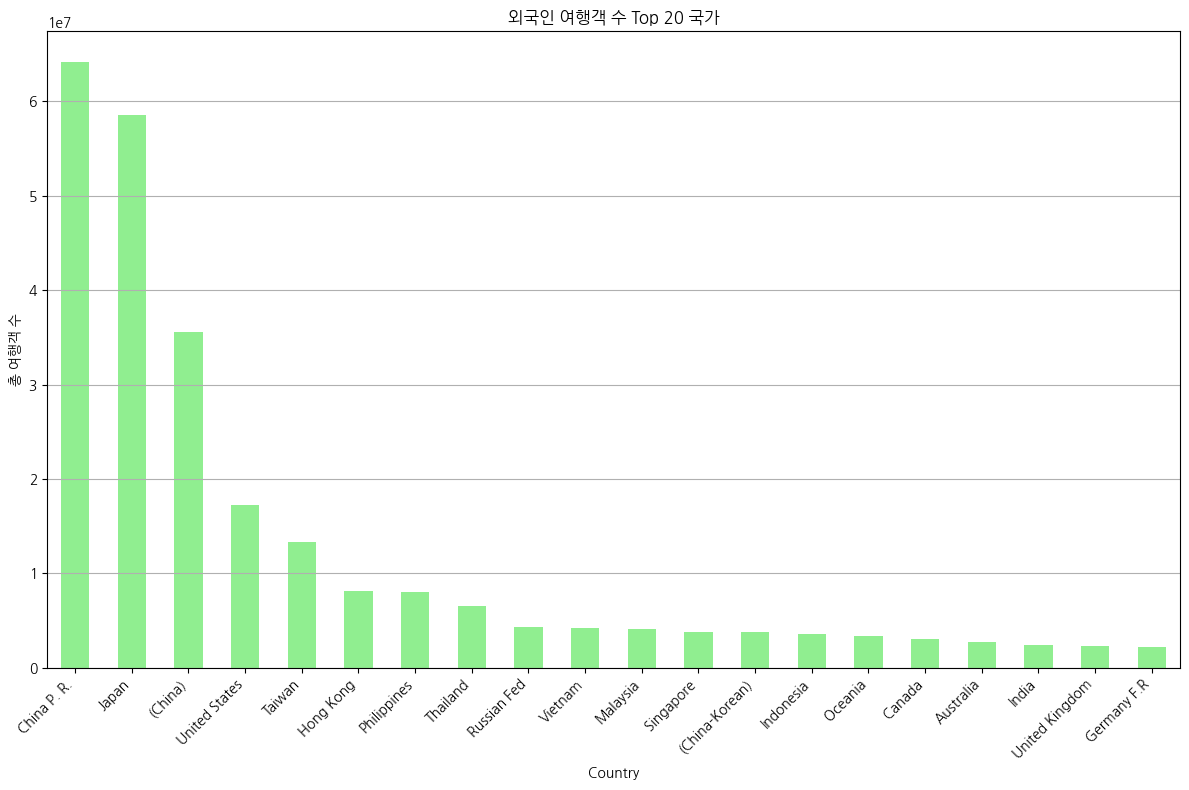

In [ ]:
# 필수 라이브러리 설치 및 임포트
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 폰트 설정
plt.rc('font', family='NanumGothic')
# 마이너스 부호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 파일 읽기
df = pd.read_csv("환율대비_여행객수.csv", encoding="utf-8")

# 전처리: 여행객 수 결측치 제거
df_clean = df.dropna(subset=['visitors'])

# 집계용 이름 제거 (실제 국가만 필터링)
exclude_keywords = ['TOTAL', 'Foreign', 'ASIA', 'Europe', 'Americas', 'Overseas']
real_countries_df = df_clean[~df_clean['Country'].str
                             .contains('|'.join(exclude_keywords), case=False)]
# 'Hong Kong, China(including Hong Kong ID.)' 국가명을 'Hong Kong'으로 변경
real_countries_df['Country'] = real_countries_df['Country'].replace(
    'Hong Kong, China(including Hong Kong ID.)', 'Hong Kong'
)

# 국가별 여행객 합계
top20_real_countries = real_countries_df.groupby('Country')['visitors'].sum().sort_values(ascending=False).head(20)

# 시각화
plt.figure(figsize=(12, 8))
top20_real_countries.plot(kind='bar', color='lightgreen')
plt.title('외국인 여행객 수 Top 20 국가')
plt.ylabel('총 여행객 수')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
# 앞서 여행객 수와 환율을 병합한 데이터를 기반으로 실제 국가를 대상으로 여행객 수만 집계해 상위 20개국을 선정해 시각화한 결과입니다.
# 단순한 총합 집계가 아니라, 'Asia’, 'Total’,‘Foreign’처럼 국가가 아닌 항목들은 제외하고 실제 국가명 기준으로 필터링한 것이 특징입니다.
# 또한, 'Hong Kong, China(including Hong Kong ID.)'처럼 긴 이름은 혼동을 피하기 위해 간단히‘Hong Kong’으로 표기해 통일했습니다.
# 이 결과를 통해 어떤 국가에서 한국을 많이 방문하는지 알 수 있고 특정 국가의 비중이 높다면
# 그 나라와의 문화 교류나 마케팅 전략에도 참고할 수 있습니다.

In [ ]:
# TOP20 국가 여행객 산점도 그래프
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# CSV 불러오기
df = pd.read_csv("여행객수_환율추이_그래프.csv", encoding="cp949")

# 날짜 처리
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year   # 연도 추출
df = df[df['Country'] != 'G.TOTAL']

# 연도별 국가 평균 방문객 수 계산
df_grouped = df.groupby(['Country','year'])['visitors'].mean().reset_index()

# 상위 20개 국가만 선택 (총 방문객 수 기준)
top_countries = df_grouped.groupby('Country')['visitors'].sum().sort_values(ascending=False).head(20).index
df_top = df_grouped[df_grouped['Country'].isin(top_countries)].copy()

# 산점도
plt.figure(figsize=(15,8))

# y축 숫자로 변환 + jitter 적용
y_pos = df_top['Country'].astype('category').cat.codes
y_jitter = y_pos + np.random.uniform(-0.2, 0.2, size=len(y_pos))

scatter = plt.scatter(
    x=df_top['year'],
    y=y_jitter,
    s=df_top['visitors']/1000,  # 점 크기
    c=df_top['visitors'],       # 점 색상
    cmap='YlOrRd',
    alpha=0.7,
    edgecolors='k'
)

plt.yticks(ticks=np.arange(len(top_countries)), labels=top_countries)
plt.colorbar(scatter, label='여행객 수')
plt.xlabel("연도", fontsize=14)
plt.ylabel("국가", fontsize=14)
plt.title("상위 20개 국가 여행객 수 산점도 (연 단위)", fontsize=18)
plt.xticks(rotation=45, ha='right'),
plt.grid(False)
plt.show()

In [ ]:
# 환율 시각화 그래프
import matplotlib.pyplot as plt
import pandas as pd

dt = pd.read_csv('환율대비_여행객수.csv')

# 날짜는 datetime 그대로 유지 (문자열로 바꾸지 않음!)
dt['date'] = pd.to_datetime(dt['date'])

plt.figure(figsize=(20, 10))
# 날짜를 x축으로, USD/KRW 환율을 y축으로 하여 초록색 선 그래프를 그림
plt.plot(dt['date'], dt['usd_krw'], label='USD/KRW 환율', color='green')
# JPY/KRW 환율은 빨간색 선으로 그림
plt.plot(dt['date'], dt['jpy100_krw'], label='JPY/KRW 환율', color='red')
# EUR/KRW 환율은 진한 파란색 선으로 그림
plt.plot(dt['date'], dt['eur_krw'], label='EUR/KRW 환율', color='darkblue')

# x축 날짜 포맷팅 자동 처리
plt.gcf().autofmt_xdate()  # x축 날짜 회전 + 간격 자동 조정

plt.xlabel('날짜',fontsize=18)
plt.ylabel('환율(원)',fontsize=18)
plt.title('달러/엔화/유로화 환율 그래프',fontsize=22)
plt.legend()
plt.grid(True)        # 그리드(격자) 표시
plt.tight_layout()    # 그래프 내부 여백 자동 조정
plt.show()

dt = dt.to_csv('여행객수_환율추이_그래프.csv',encoding='cp949')

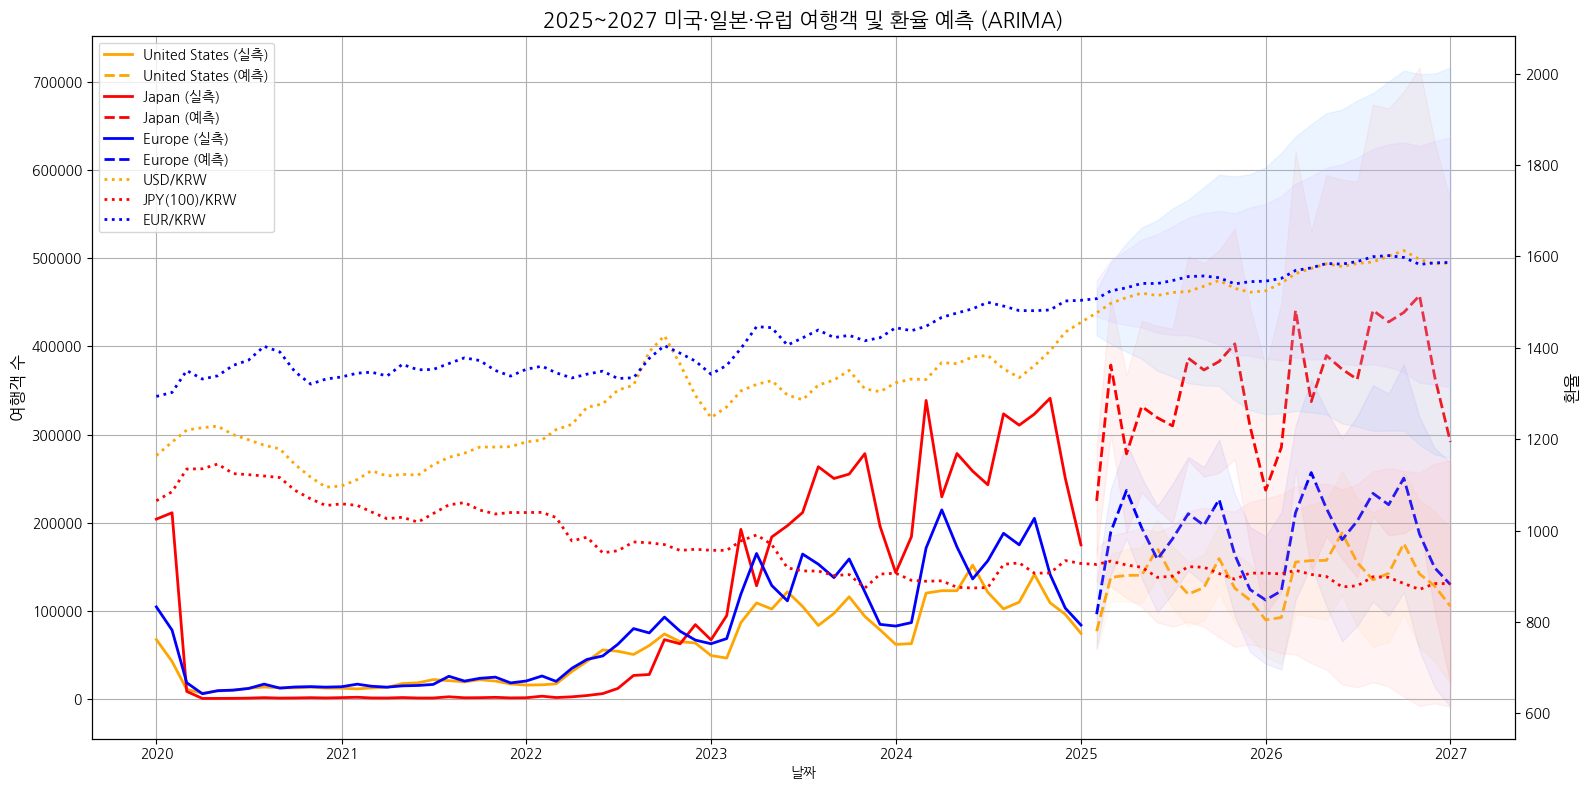

In [ ]:
# ARIMA 예측 시각화
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

# 한글 폰트 설정
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings("ignore")

# -------------------- 데이터 로딩 --------------------
df = pd.read_csv("환율대비_여행객수.csv", encoding="utf-8")
df["date"] = pd.to_datetime(df["date"], format="%Y-%m", errors="coerce")
df = df.dropna(subset=["date"]).sort_values("date")

# 유럽 국가 묶기
europe_countries = [
    "United Kingdom", "Germany", "France", "Italy", "Spain",
    "Netherlands", "Sweden", "Norway", "Denmark", "Finland",
    "Switzerland", "Austria", "Belgium", "Ireland", "Greece",
    "Portugal", "Poland", "Czech Republic", "Hungary"
]
# df에서 유럽 국가에 해당하는 데이터만 추출
df_europe = df[df["Country"].isin(europe_countries)].copy()

# 유럽 국가들의 월별 방문객 수를 모두 합쳐서 하나의 "Europe"으로 그룹핑
df_europe_grouped = df_europe.groupby("date")["visitors"].sum().reset_index()

# 새롭게 만든 그룹에 국가명을 "Europe"으로 지정
df_europe_grouped["Country"] = "Europe"

# 유럽 외의 다른 국가 데이터는 그대로 사용
df_non_europe = df[~df["Country"].isin(europe_countries)]
# 유럽 그룹 데이터와 나머지 국가 데이터를 합침
df_final = pd.concat([df_non_europe, df_europe_grouped], ignore_index=True)
# Country, date 기준으로 정렬 후 인덱스 리셋
df_final = df_final.sort_values(["Country", "date"]).reset_index(drop=True)

# 환율 데이터 준비
fx_cols = ["usd_krw", "jpy100_krw", "eur_krw"]
fx_df = df.groupby("date")[fx_cols].mean().reset_index()
fx_df["date"] = pd.to_datetime(fx_df["date"])
fx_df.set_index("date", inplace=True)

# -------------------- 예측 설정 --------------------
# 예측 대상 국가 리스트 설정
target_countries = ["United States", "Japan", "Europe"]

# 학습 데이터의 종료일 (실제 데이터는 2025년 1월까지 사용)
cutoff_date = pd.to_datetime("2025-01-01")

# 예측 기간: 이후 24개월 (2025년 2월 ~ 2027년 1월)
forecast_periods = 24
future_dates = pd.date_range(start=cutoff_date + pd.DateOffset(months=1),
                             periods=forecast_periods, freq="MS") # 월별 시작일
# 결과 저장용 딕셔너리
results = {}

# 각 국가별로 예측 수행
for country in target_countries:
    # 해당 국가 데이터만 필터링
    country_df = df_final[df_final["Country"] == country]
    # 날짜별 여행객 수 집계
    country_df = country_df.groupby("date")["visitors"].sum().reset_index()
    # 날짜를 인덱스로 설정 (시계열로 만들기 위해)
    country_df.set_index("date", inplace=True)
    # 학습용 데이터: 2020년 1월부터 cutoff_date까지
    train = country_df.loc["2020-01-01":cutoff_date]

    # ARIMA 모델 정의 및 학습
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    result = model.fit(disp=False)

    # 24개월간 예측 수행
    forecast = result.get_forecast(steps=forecast_periods)
    forecast_df = forecast.summary_frame()

    # 예측 결과에서 필요한 컬럼만 숫자로 변환
    forecast_df = forecast_df[["mean", "mean_ci_lower", "mean_ci_upper"]].apply(
        pd.to_numeric, errors="coerce")
    # 국가명 및 날짜 추가
    forecast_df["country"] = country
    forecast_df["date"] = future_dates

    # 실측 데이터 전처리: 열 이름 변경 및 태그 추가
    train = train.reset_index()
    train["type"] = "actual"
    train["country"] = country
    train.rename(columns={"visitors": "value"}, inplace=True)

    # 예측 데이터 전처리: 열 이름 및 태그
    forecast_df.rename(columns={"mean": "value"}, inplace=True)
    forecast_df["type"] = "forecast"

    # 실측과 예측 데이터를 하나로 병합
    combined = pd.concat([
        train[["date", "value", "country", "type"]],
        forecast_df[["date", "value", "country", "type", "mean_ci_lower",
                     "mean_ci_upper"]]
    ], ignore_index=True)

    # 국가별로 결과 저장
    results[country] = combined

# -------------------- 환율 예측 --------------------
# 각 통화별 예측 구간 색상 설정
color_map = {"usd_krw": "#84c1ff","jpy100_krw": "#ffb3b3","eur_krw": "#d2b4ff"}

# 예측 결과를 저장할 딕셔너리 (값과 신뢰구간 분리 저장)
fx_forecasts = {}   # 평균 예측값 저장
fx_ci_bounds = {}   # 신뢰구간(상/하단) 저장

# 환율 컬럼별로 반복 예측
for col in fx_cols:
    # 2020~2025.01 사이의 환율 학습 데이터 선택
    fx_train = fx_df[col].loc["2020-01-01":cutoff_date].dropna()
    # ARIMA 계절모델 구성 및 적합
    model = SARIMAX(fx_train, order=(1,1,1), seasonal_order=(1,1,1,12))
    result = model.fit(disp=False)
    # 24개월 예측
    forecast = result.get_forecast(steps=forecast_periods)
    forecast_df = forecast.summary_frame()
    forecast_df.index = future_dates # 예측 인덱스 future_dates로 설정
    # 예측 평균값 저장
    fx_forecast = forecast_df["mean"]
    fx_forecasts[col] = pd.concat([fx_train, fx_forecast])  # 과거 + 미래
    # 신뢰구간 저장
    fx_ci_bounds[col] = {
        "lower": forecast_df["mean_ci_lower"],
        "upper": forecast_df["mean_ci_upper"]}

# -------------------- 여행객수 시각화 --------------------
fig, ax1 = plt.subplots(figsize=(16, 8))
colors = {"United States": "orange", "Japan": "red", "Europe": "blue"}
# 여행객수 시각화
for country in target_countries:

    data = results[country]                      # 해당 국가 예측 결과 호출
    actual = data[data["type"] == "actual"]      # 실측 데이터
    forecast = data[data["type"] == "forecast"]  # 예측 데이터
    c = colors[country]
    # 실측 값 그래프 (실선)
    ax1.plot(actual["date"], actual["value"], label=f"{country} (실측)",
             color=c, linewidth=2)
    # 예측 값 그래프 (점선)
    ax1.plot(forecast["date"], forecast["value"], label=f"{country} (예측)",
             linestyle="--", color=c, linewidth=2)
    # 예측 신뢰구간 시각화
    ax1.fill_between(forecast["date"], forecast["mean_ci_lower"],
                     forecast["mean_ci_upper"], color=c, alpha=0.05)

# y축(왼쪽): 여행객 수
ax1.set_ylabel("여행객 수", fontsize=12)
ax1.set_xlabel("날짜")
ax1.tick_params(axis='y')
ax1.set_title("2025~2027 미국·일본·유럽 여행객 및 환율 예측 (ARIMA)",
              fontsize=15)
ax1.grid(True)

# -------------------- 환율 시각화 --------------------
ax2 = ax1.twinx()   # y축을 오른쪽에 하나 더 추가 (환율용)
# 각 환율에 대해 시각화
for col, label, line_color in zip(fx_cols,
 ["USD/KRW", "JPY(100)/KRW", "EUR/KRW"], ["orange", "red", "blue"]):
    # 환율 추이 (실측 + 예측 포함)
    ax2.plot(fx_forecasts[col], label=label,
             color=line_color, linestyle=":", linewidth=2)
    # 환율 예측 신뢰구간 시각화
    ax2.fill_between(future_dates,
                     fx_ci_bounds[col]["lower"],
                     fx_ci_bounds[col]["upper"],
                     color=color_map[col],   # 위에서 지정한 색상
                     alpha=0.15)
# y축(오른쪽): 환율
ax2.set_ylabel("환율", fontsize=12)
ax2.tick_params(axis='y')

# -------------------- 결과 --------------------
# 왼쪽 y축(방문객) + 오른쪽 y축(환율) 모두 수집
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left",
           fontsize=10)
# 전체 레이아웃 정리 및 출력
plt.tight_layout()
plt.show()


In [ ]:
# 2025년부터 2027년까지를 대상으로, 경제 규모가 큰 미국·일본·유럽국가에서 오는 외국인 여행객 수와 해당 국가의 환율 변화를
# ARIMA 모델을 활용해 예측한 결과를 시각화한 것입니다.
# ※ 실선은 실제 데이터(2020/01~2025/01)를 의미하고, 점선은 모델이 예측한 값(2025/02~2027/01)을 보여줍니다.
# ※ 색상은 국가별로 구분했고, 각 국가의 예측 구간에는 밝은 음영으로 신뢰 구간을 표시하여 불확실성 범위도 함께 제시했습니다.
# ※ 오른쪽 축은 환율입니다. USD/KRW, JPY(100)/KRW, EUR/KRW 의 환율도 함께 예측했고, 점선 그래프와 흐릿한 색상 음영으로 미래 환율의 변동성과 추세를 시각화했습니다.
# 이 예측 그래프는 단순히 여행객 수만 보는 게 아니라, 환율과의 관계성까지 고려하여 여행 수요에 어떤 영향을 줄 수 있는지를
# 통합적으로 분석하려는 시도였습니다. 예를 들어 원화 대비 달러나 유로가 강세를 보이면 해외에서 한국 여행이 상대적으로 저렴해져서
# 방문객 수가 늘어날 가능성도 있습니다. 또한 이런 식의 시계열 분석은 관광 정책 수립, 마케팅 전략, 환율 리스크 관리 측면에서
# 실질적인 참고 자료로 활용될 수 있습니다.